In [1]:
# public libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## read in the data

In [2]:
# we'll read both of these values and the original input and irrelevant tcrs
X_cdr3s = pd.read_csv('../outputs/model_v3/cdr3.conversion.csv', index_col=0)
X_epitopes = pd.read_csv('../outputs/model_v3/epitope.conversion.csv', index_col=0)
hit = pd.read_csv('../outputs/model_v3/full.input.X.csv', index_col=0)
irr = pd.read_csv('../outputs/model_v3/full.control.X.csv', index_col=0)
irr = irr.reset_index().iloc[:, 1:]

## prepare the data for modeling

In [3]:
# grab a subset
np.random.seed(0)
n_rows = 50000
perc_train = 0.75
# > subset target
idxs = np.random.choice(hit.index, size=n_rows, replace=False)
idxs, idys = idxs[:round(n_rows * perc_train)], idxs[round(n_rows * perc_train):]
print(len(idxs), len(idys))
hit, hit_test = hit.loc[idxs], hit.loc[idys]
# > subset control
idxs = np.random.choice(irr.index, size=n_rows, replace=False)
idxs, idys = idxs[:round(n_rows * perc_train)], idxs[round(n_rows * perc_train):]
print(len(idxs), len(idys))
irr, irr_test = irr.loc[idxs], irr.loc[idys]

37500 12500
37500 12500


In [4]:
# create X for training
X_train = hit.append(irr).reset_index().iloc[:, 1:]
X_train_cdr3s = X_cdr3s.loc[X_train['CDR3']].reset_index().iloc[:, 1:]
X_train_epitopes = X_epitopes.loc[X_train['Epitope']].reset_index().iloc[:, 1:]
# combine
X_train_cdr3s.columns = 'cdr3:' + X_train_cdr3s.columns
X_train_epitopes.columns = 'ag:' + X_train_epitopes.columns
X_train = X_train_cdr3s.join(X_epitopes)

# grab y for training
y_train = pd.Series(np.ones(hit.shape[0])).append(pd.Series(np.zeros(irr.shape[0]))).astype(int)
y_train = y_train.reset_index().iloc[:, 1:][0]

In [5]:
# create X for testing
X_test = hit_test.append(irr_test).reset_index().iloc[:, 1:]
X_test_cdr3s = X_cdr3s.loc[X_test['CDR3']].reset_index().iloc[:, 1:]
X_test_epitopes = X_epitopes.loc[X_test['Epitope']].reset_index().iloc[:, 1:]
# combine
X_test_cdr3s.columns = 'cdr3:' + X_test_cdr3s.columns
X_test_epitopes.columns = 'ag:' + X_test_epitopes.columns
X_test = X_test_cdr3s.join(X_test_epitopes)

# grab y for testing
y_test = pd.Series(np.ones(hit_test.shape[0])).append(pd.Series(np.zeros(irr_test.shape[0]))).astype(int)
y_test = y_test.reset_index().iloc[:, 1:][0]

In [6]:
# remove any columns that are constant or all zero
X_train = X_train.loc[:, X_train.abs().sum(0) > 0]
X_train = X_train.loc[:, X_train.nunique(0) > 1]
# now display the number of arguments post filtering
X_train.shape[1]

2471

In [7]:
# normalize
means = X_train.mean()
X_train -= X_train.mean()
stds = X_train.std()
X_train /= X_train.std()
# normalize test
X_test = X_test[X_train.columns]
X_test -= means
X_test /= stds
# write normalization factors
means.to_csv('../outputs/model_v4/model_v4.means.csv')
stds.to_csv('../outputs/model_v4/model_v4.stds.csv')

## create the model using tensorflow

In [8]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

%load_ext tensorboard

2023-08-24 19:17:34.938884: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 19:17:35.073349: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-24 19:17:35.680614: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-24 19:17:35.680707: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [9]:
# determine model parameters
model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1])),
    keras.layers.Dense(1000, activation='sigmoid'),
    keras.layers.Dense(500, activation='sigmoid'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              2472000   
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 dense_2 (Dense)             (None, 1)                 501       
                                                                 
Total params: 2,973,001
Trainable params: 2,973,001
Non-trainable params: 0
_________________________________________________________________


2023-08-24 19:17:36.415174: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-08-24 19:17:36.415215: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-08-24 19:17:36.415663: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# set up the training parameters for the model
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy','AUC'],
)

In [11]:
# train the model
history = model.fit(X_train, y_train,
                    epochs=25,
                    validation_data=(X_test, y_test),
                    workers=40, use_multiprocessing=True)

Epoch 1/25
2344/2344 [==============================] - 24s 10ms/step - loss: 0.6582 - accuracy: 0.5793 - auc: 0.6268 - val_loss: 0.6409 - val_accuracy: 0.5931 - val_auc: 0.6623
Epoch 2/25
2344/2344 [==============================] - 22s 9ms/step - loss: 0.6377 - accuracy: 0.6027 - auc: 0.6607 - val_loss: 0.6325 - val_accuracy: 0.6164 - val_auc: 0.6799
Epoch 3/25
2344/2344 [==============================] - 22s 9ms/step - loss: 0.6193 - accuracy: 0.6274 - auc: 0.6944 - val_loss: 0.6261 - val_accuracy: 0.6244 - val_auc: 0.6921
Epoch 4/25
2344/2344 [==============================] - 22s 9ms/step - loss: 0.5922 - accuracy: 0.6643 - auc: 0.7387 - val_loss: 0.6241 - val_accuracy: 0.6407 - val_auc: 0.7111
Epoch 5/25
2344/2344 [==============================] - 22s 9ms/step - loss: 0.5504 - accuracy: 0.7103 - auc: 0.7899 - val_loss: 0.6145 - val_accuracy: 0.6543 - val_auc: 0.7219
Epoch 6/25
2344/2344 [==============================] - 22s 9ms/step - loss: 0.5062 - accuracy: 0.7510 - auc: 0.83

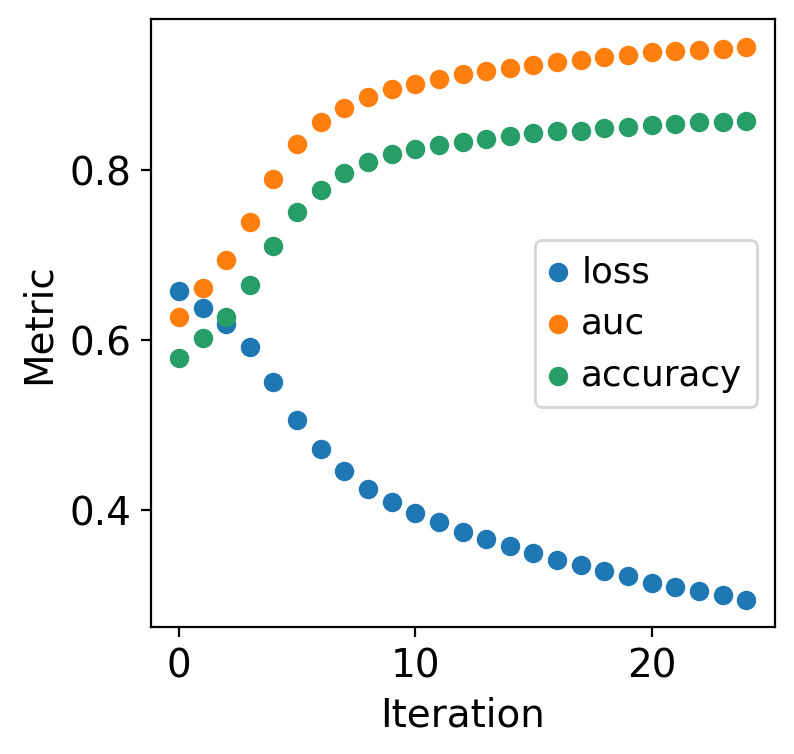

In [24]:
# check the metrics to confirm convergence
plt.scatter(range(25), history.history['loss'], label='loss')
plt.scatter(range(25), history.history['auc'], label='auc')
plt.scatter(range(25), history.history['accuracy'], label='accuracy')
plt.grid(False)
plt.xlabel('Iteration')
plt.ylabel('Metric')
plt.legend()

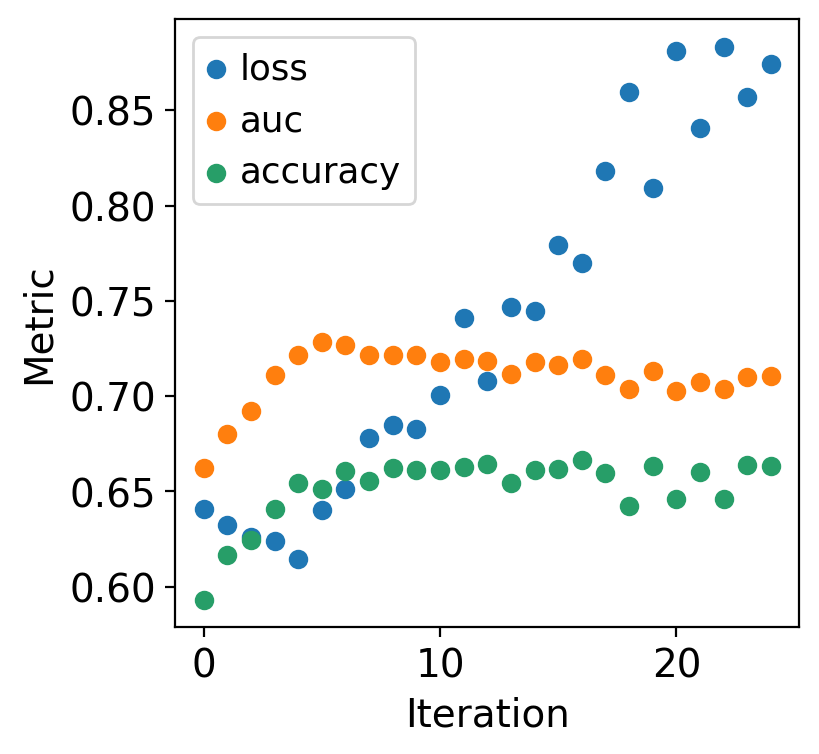

In [25]:
# check the metrics to confirm convergence
plt.scatter(range(25), history.history['val_loss'], label='loss')
plt.scatter(range(25), history.history['val_auc'], label='auc')
plt.scatter(range(25), history.history['val_accuracy'], label='accuracy')
plt.grid(False)
plt.xlabel('Iteration')
plt.ylabel('Metric')
plt.legend()

In [12]:
# get it in nice plotting stage
import scanpy as sc
sc.settings.set_figure_params(dpi=100)

In [29]:
def confirm_training():
    # training predictions
    y_pred = model.predict(X_train, workers=40, use_multiprocessing=True)[:, 0]
    y_pred = pd.Series(y_pred, index=y_train.index, name='Pred%')
    y_pred = pd.concat([y_pred, y_train], axis=1)

    # training plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[3.5, 4])
    ax1.grid(False); ax2.grid(False)

    sns.barplot(x=0, y='Pred%', data=y_pred, ci=95, errwidth=1.5, capsize=0.3,
                ax=ax1, order=[0, 1], saturation=1)

    sns.barplot(x=0, y='Pred%', data=y_pred, ci=95, errwidth=1.5, capsize=0.3,
                ax=ax2, order=[0, 1], saturation=1)
    sns.stripplot(x=0, y='Pred%', data=y_pred, jitter=0.25, alpha=0.01,
                  ax=ax2, order=[0, 1], edgecolor='k', linewidth=0.5)

    ax1.set_xlabel('Hit = 1'); ax2.set_xlabel('Hit = 1')

    fig.tight_layout()

In [30]:
def validate_model():
    # testing predictions
    y_pred = model.predict(X_test, workers=40, use_multiprocessing=True)[:, 0]
    y_pred = pd.Series(y_pred, index=y_test.index, name='Pred%')
    y_pred = pd.concat([y_pred, y_test], axis=1)

    # testing plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[3.5, 4])
    ax1.grid(False); ax2.grid(False)

    sns.barplot(x=0, y='Pred%', data=y_pred, ci=95, errwidth=1.5, capsize=0.3,
                ax=ax1, order=[0, 1], saturation=1)

    sns.barplot(x=0, y='Pred%', data=y_pred, ci=95, errwidth=1.5, capsize=0.3,
                ax=ax2, order=[0, 1], saturation=1)
    sns.stripplot(x=0, y='Pred%', data=y_pred, jitter=0.25, alpha=0.01,
                  ax=ax2, order=[0, 1], edgecolor='k', linewidth=0.5)

    ax1.set_xlabel('Hit = 1'); ax2.set_xlabel('Hit = 1')

    fig.tight_layout()

782/782 [==============================] - 3s 4ms/step


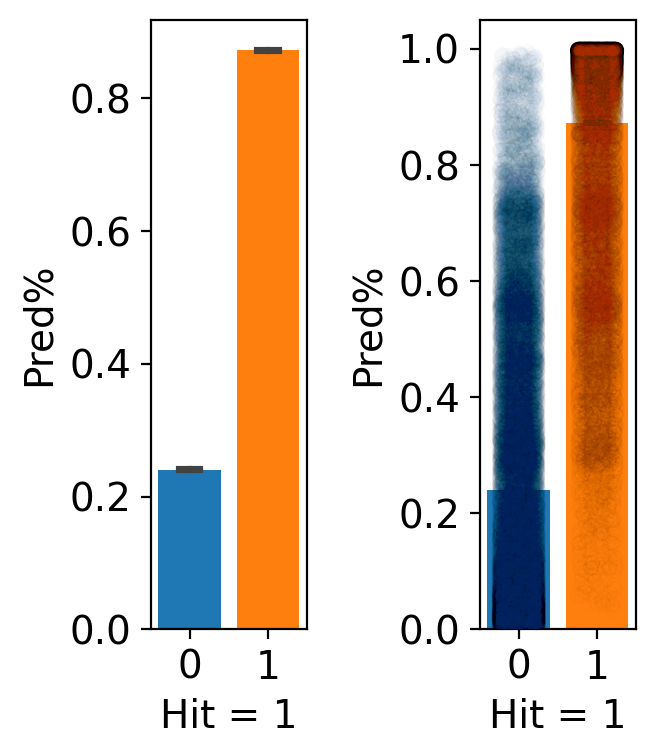

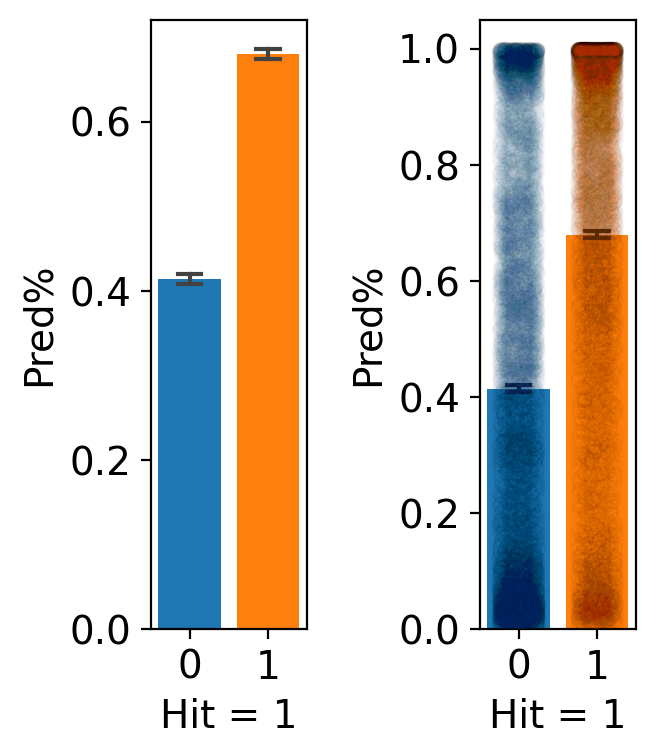

In [31]:
# check to see how well we're doing
confirm_training()
validate_model()

In [52]:
from sklearn.metrics import roc_curve
# testing predictions
y_pred = model.predict(X_test, workers=40, use_multiprocessing=True)[:, 0]
y_pred = pd.Series(y_pred, index=y_test.index, name='Pred%')
y_pred = pd.concat([y_pred, y_test], axis=1)

fpr, tpr, _ = roc_curve(y_pred[0], y_pred['Pred%'])

782/782 [==============================] - 3s 4ms/step


Validation AUC 0.710857312


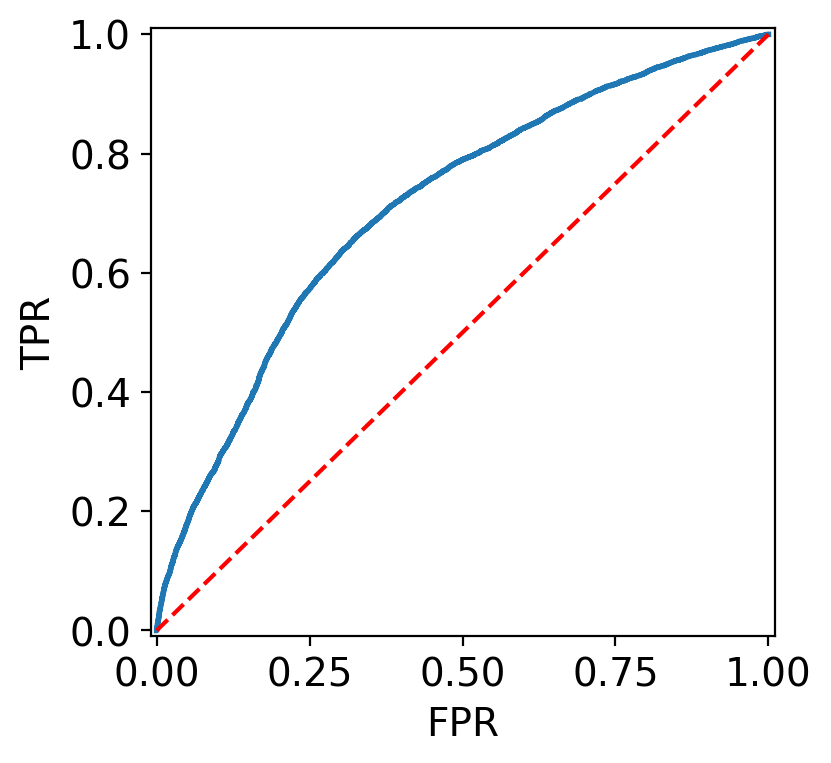

In [53]:
# check the AUC
plt.plot(fpr, tpr, lw=2)
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.grid(False)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
print('Validation AUC', auc(fpr, tpr))

In [48]:
from sklearn.metrics import roc_curve
# testing predictions
y_pred = model.predict(X_train, workers=40, use_multiprocessing=True)[:, 0]
y_pred = pd.Series(y_pred, index=y_train.index, name='Pred%')
y_pred = pd.concat([y_pred, y_train], axis=1)

fpr, tpr, _ = roc_curve(y_pred[0], y_pred['Pred%'])

2344/2344 [==============================] - 10s 4ms/step


Training AUC 0.9620291786666666


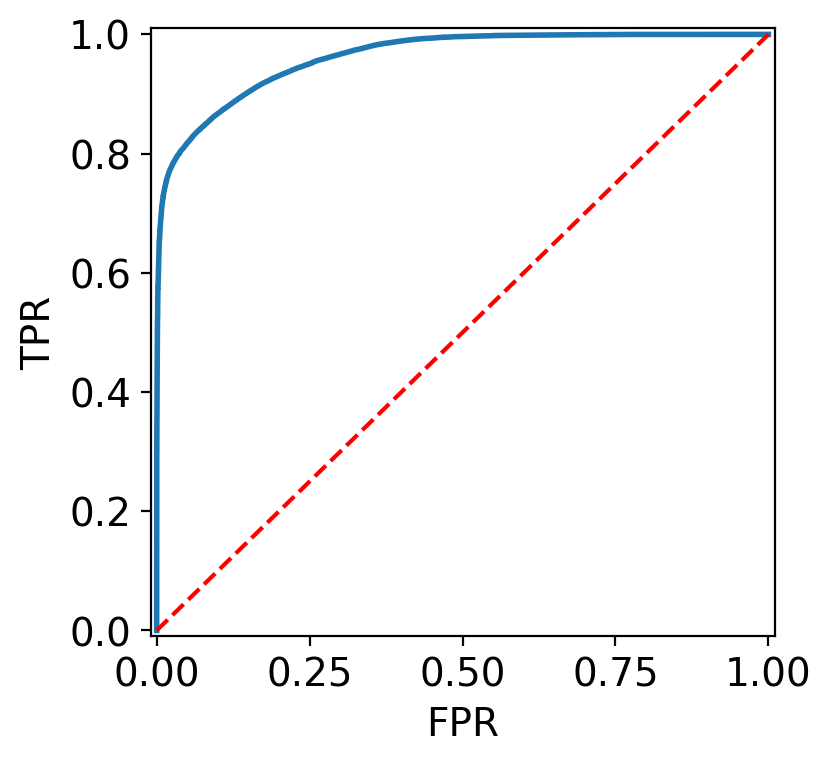

In [51]:
# check the AUC
plt.plot(fpr, tpr, lw=2)
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.grid(False)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
print('Training AUC', auc(fpr, tpr))